In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

## Model 1: Linear Regression

In [2]:
df_linear = pd.read_csv(r"https://raw.githubusercontent.com/Mlzzzzz/MSU_CMSE830_Webapp/main/Datasets/preprocessed_dataset.csv")
features_linear = df_linear[["tanimoto_cdk_Extended", "TanimotoCombo"]]
targets_linear = df_linear[["frac_similar"]].values

In [3]:
# Grid search for linear regression
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lasso = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search_ridge.fit(features_linear, targets_linear)
grid_search_lasso.fit(features_linear, targets_linear)

best_params_ridge = grid_search_ridge.best_params_
best_mse_ridge = -grid_search_ridge.best_score_
best_params_lasso = grid_search_lasso.best_params_
best_mse_lasso = -grid_search_lasso.best_score_

model_linear = LinearRegression()
mse_scores_linear_cv = -cross_val_score(model_linear, features_linear, targets_linear, cv=5, scoring='neg_mean_squared_error')

# Calculate the average MSE across the cross-validation folds
avg_mse_linear_cv = np.mean(mse_scores_linear_cv)

print("Average MSE for Simple Linear Regression with CV:", avg_mse_linear_cv)
print("Best parameters for Ridge:", best_params_ridge, "| Best MSE for Ridge:", best_mse_ridge)
print("Best parameters for Lasso:", best_params_lasso, "| Best MSE for Lasso:", best_mse_lasso)

Average MSE for Simple Linear Regression with CV: 0.020640713081397345
Best parameters for Ridge: {'alpha': 0.001} | Best MSE for Ridge: 0.02064115985356263
Best parameters for Lasso: {'alpha': 0.001} | Best MSE for Lasso: 0.020898367542994307


In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Prepare an array to store the predictions
predictions = np.zeros(len(df_linear))

# Iterate through each fold
for train_index, test_index in kf.split(features_linear):
    X_train, X_test = features_linear.iloc[train_index], features_linear.iloc[test_index]
    y_train, y_test = targets_linear[train_index], targets_linear[test_index]

    # Define the model
    model = LinearRegression()
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    preds = model.predict(X_test).flatten()

    # Store predictions
    predictions[test_index] = preds

# Add predictions back to the original DataFrame
df_linear['cv_predicted_linear'] = predictions

In [5]:
df_linear['pred_similar'] = (df_linear['cv_predicted_linear'] > 0.5).astype(int)
df_linear.head(5)

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_linear,pred_similar
0,1,0.567010,1.989,0.31,CYP2D6,"dis2D,sim3D",0.818182,1,0.637009,1
1,2,0.532051,1.782,0.34,HERG,"dis2D,sim3D",0.562500,1,0.580133,1
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,0.604678,1
3,4,0.558952,1.764,1.30,HERG,"dis2D,sim3D",0.750000,1,0.572075,1
4,5,0.452685,1.757,0.50,CYP2D6,"dis2D,sim3D",0.652174,1,0.499436,0


In [6]:
# find the misclassified pairs
mask = df_linear['similar'] != df_linear['pred_similar']

different_rows_linear = df_linear[mask]

different_rows_linear  

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_linear,pred_similar
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,0.604678,1
4,5,0.452685,1.757,0.50,CYP2D6,"dis2D,sim3D",0.652174,1,0.499436,0
5,6,0.626190,1.757,1.44,5HT2B,"dis2D,sim3D",0.411765,0,0.629259,1
8,9,0.387879,1.674,0.40,HERG,"dis2D,sim3D",0.727273,1,0.428456,0
17,18,0.602537,1.460,1.11,HERG,"dis2D,sim3D",0.448276,0,0.539212,1
19,20,0.608200,1.454,0.70,5HT2B,"dis2D,sim3D",0.480000,0,0.533487,1
22,23,0.348558,1.444,1.09,HERG,"dis2D,sim3D",0.550000,1,0.338697,0
28,29,0.848238,1.137,0.12,CYP2D6,"sim2D,dis3D",0.478261,0,0.569067,1
29,30,0.829787,1.271,0.30,CYP2D6,"sim2D,dis3D",0.500000,0,0.599953,1
31,32,0.801587,1.275,0.60,CYP2D6,"sim2D,dis3D",0.380952,0,0.591288,1


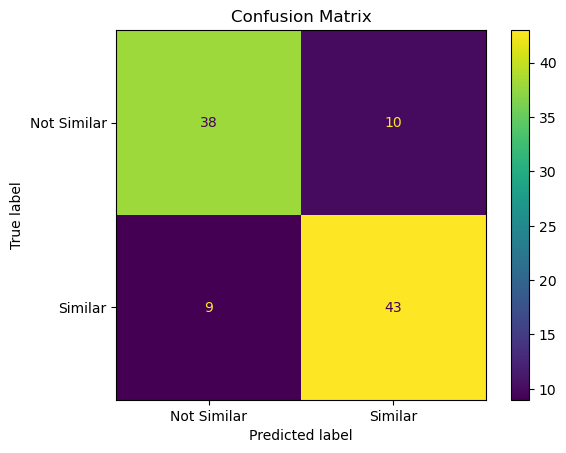

In [7]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = df_linear['similar']
y_pred = df_linear['pred_similar']
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(values_format='d')
plt.title('Confusion Matrix')
plt.show()

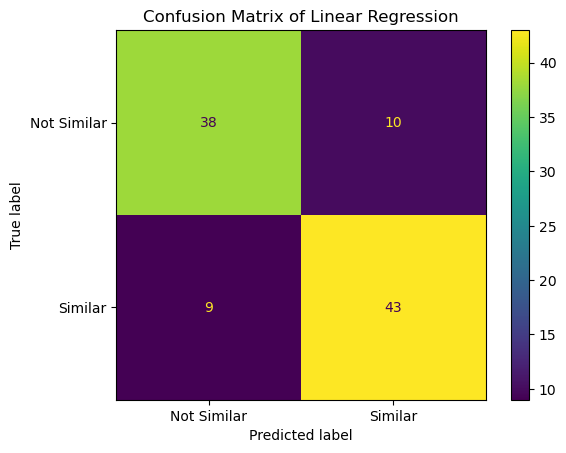

In [8]:
cm = np.array([[38, 10], [9, 43]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix of Linear Regression')
plt.show()

## Model 2: Logistic Regression

In [9]:
df_log = pd.read_csv(r"https://raw.githubusercontent.com/Mlzzzzz/MSU_CMSE830_Webapp/main/Datasets/preprocessed_dataset.csv")
features_log =  df_log[["tanimoto_cdk_Extended", "TanimotoCombo"]]
targets_log = df_log["similar"].values

In [10]:
# Scale the features
scaler = StandardScaler()
scaled_features_log = scaler.fit_transform(features_log)

In [11]:
# Grid search for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['saga'] 
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(scaled_features_log, targets_log)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Best accuracy: 0.8400000000000001


In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Prepare an array to store the predictions
predictions = np.zeros(len(df_log))

# Iterate through each fold
for train_index, test_index in kf.split(scaled_features_log):
    X_train, X_test = scaled_features_log[train_index], scaled_features_log[test_index]
    y_train, y_test = targets_log[train_index], targets_log[test_index]

    # Define the model
    model = LogisticRegression(C=0.01, penalty='l2', solver='saga')
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    preds = model.predict(X_test).flatten()

    # Store predictions
    predictions[test_index] = preds

# Add predictions back to the original DataFrame
df_log['cv_predicted_log'] = predictions

In [13]:
df_log.head(5)

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_log
0,1,0.567010,1.989,0.31,CYP2D6,"dis2D,sim3D",0.818182,1,1.0
1,2,0.532051,1.782,0.34,HERG,"dis2D,sim3D",0.562500,1,1.0
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,1.0
3,4,0.558952,1.764,1.30,HERG,"dis2D,sim3D",0.750000,1,1.0
4,5,0.452685,1.757,0.50,CYP2D6,"dis2D,sim3D",0.652174,1,1.0


In [14]:
# find the misclassified pairs
mask = df_log['similar'] != df_log['cv_predicted_log']

different_rows_log = df_log[mask]

different_rows_log

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_log
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,1.0
5,6,0.626190,1.757,1.44,5HT2B,"dis2D,sim3D",0.411765,0,1.0
8,9,0.387879,1.674,0.40,HERG,"dis2D,sim3D",0.727273,1,0.0
16,17,0.421756,1.502,0.25,5HT2B,"dis2D,sim3D",0.300000,0,1.0
17,18,0.602537,1.460,1.11,HERG,"dis2D,sim3D",0.448276,0,1.0
19,20,0.608200,1.454,0.70,5HT2B,"dis2D,sim3D",0.480000,0,1.0
22,23,0.348558,1.444,1.09,HERG,"dis2D,sim3D",0.550000,1,0.0
23,24,0.538003,1.437,0.00,HERG,"dis2D,sim3D",0.461538,0,1.0
28,29,0.848238,1.137,0.12,CYP2D6,"sim2D,dis3D",0.478261,0,1.0
29,30,0.829787,1.271,0.30,CYP2D6,"sim2D,dis3D",0.500000,0,1.0


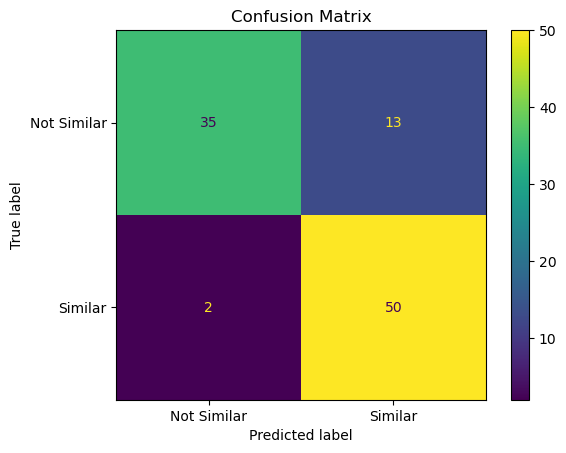

In [15]:
y_true = df_log['similar']
y_pred = df_log['cv_predicted_log']
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

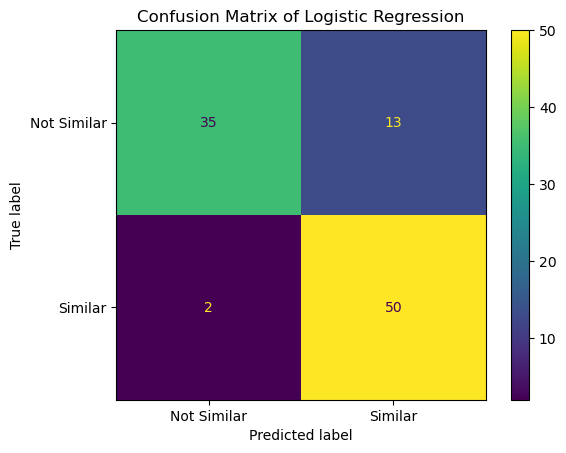

In [16]:
cm = np.array([[35, 13], [2, 50]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix of Logistic Regression')
plt.show()

## Model 3: Decision Tree

In [17]:
df_tree = pd.read_csv(r"https://raw.githubusercontent.com/Mlzzzzz/MSU_CMSE830_Webapp/main/Datasets/preprocessed_dataset.csv")
features_tree = df_tree[["tanimoto_cdk_Extended", "TanimotoCombo", "pchembl_distance"]]
targets_tree = df_tree["similar"].values

In [18]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4,  5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(features_tree, targets_tree)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

Fitting 5 folds for each of 315 candidates, totalling 1575 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best accuracy: 0.82


In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Prepare an array to store the predictions
predictions = np.zeros(len(df_tree))

# Iterate through each fold
for train_index, test_index in kf.split(features_tree):
    X_train, X_test = features_tree.iloc[train_index], features_tree.iloc[test_index]
    y_train, y_test = targets_tree[train_index], targets_tree[test_index]

    # Define the model
    model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=2)
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    preds = model.predict(X_test).flatten()

    # Store predictions
    predictions[test_index] = preds

# Add predictions back to the original DataFrame
df_tree['cv_predicted_tree'] = predictions

In [20]:
df_tree.head(5)

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_tree
0,1,0.567010,1.989,0.31,CYP2D6,"dis2D,sim3D",0.818182,1,0.0
1,2,0.532051,1.782,0.34,HERG,"dis2D,sim3D",0.562500,1,1.0
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,1.0
3,4,0.558952,1.764,1.30,HERG,"dis2D,sim3D",0.750000,1,0.0
4,5,0.452685,1.757,0.50,CYP2D6,"dis2D,sim3D",0.652174,1,0.0


In [21]:
mask = df_tree['similar'] != df_tree['cv_predicted_tree']

different_rows_tree = df_tree[mask]

different_rows_tree

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_tree
0,1,0.567010,1.989,0.31,CYP2D6,"dis2D,sim3D",0.818182,1,0.0
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,1.0
3,4,0.558952,1.764,1.30,HERG,"dis2D,sim3D",0.750000,1,0.0
4,5,0.452685,1.757,0.50,CYP2D6,"dis2D,sim3D",0.652174,1,0.0
5,6,0.626190,1.757,1.44,5HT2B,"dis2D,sim3D",0.411765,0,1.0
14,15,0.590998,1.562,0.10,5HT2B,"dis2D,sim3D",0.650000,1,0.0
17,18,0.602537,1.460,1.11,HERG,"dis2D,sim3D",0.448276,0,1.0
19,20,0.608200,1.454,0.70,5HT2B,"dis2D,sim3D",0.480000,0,1.0
20,21,0.644681,1.454,0.80,HERG,"dis2D,sim3D",0.785714,1,0.0
21,22,0.200477,1.450,3.04,5HT2B,"dis2D,sim3D",0.368421,0,1.0


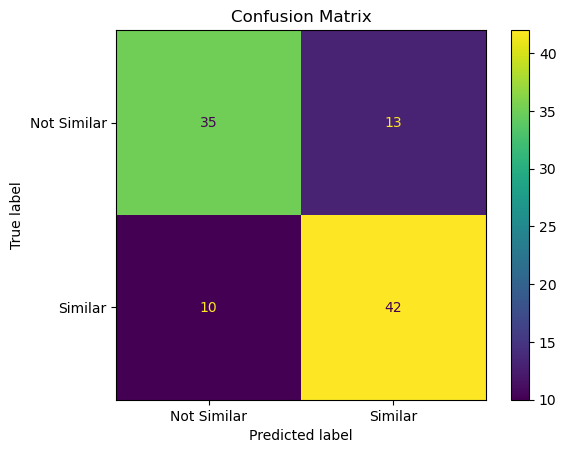

In [22]:
y_true = df_tree['similar']
y_pred = df_tree['cv_predicted_tree']
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

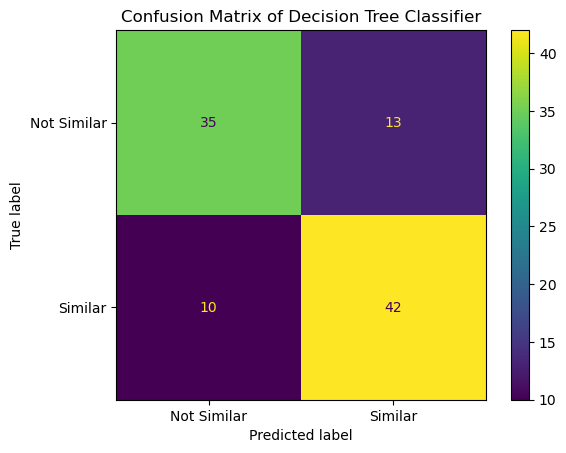

In [23]:
cm = np.array([[35, 13], [10, 42]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix of Decision Tree Classifier')
plt.show()

## Model 4: Support Vector Regression

In [24]:
df_svr = pd.read_csv("https://raw.githubusercontent.com/Mlzzzzz/MSU_CMSE830_Webapp/main/Datasets/preprocessed_dataset.csv")
features_svr = df_svr[["tanimoto_cdk_Extended", "TanimotoCombo"]]
targets_svr = df_svr["frac_similar"].values

In [25]:
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'epsilon': [0.1, 0.01, 0.001],  
    'kernel': ['rbf', 'linear', 'poly']  
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(features_svr, targets_svr.squeeze())

best_params = grid_search.best_params_
best_mse = -grid_search.best_score_ 

print("Best parameters:", best_params)
print("Best MSE:", best_mse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}
Best MSE: 0.018747738817597535


In [26]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 50, 100],
    'epsilon': [0.005, 0.01, 0.015, 0.02, 0.03],
    'kernel': ['rbf', 'linear', 'poly'],
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(features_svr, targets_svr)

best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print("Best parameters:", best_params)
print("Best MSE:", best_mse)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'C': 1, 'epsilon': 0.005, 'kernel': 'rbf'}
Best MSE: 0.018518545572375866


In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Prepare an array to store the predictions
predictions = np.zeros(len(df_svr))

# Iterate through each fold
for train_index, test_index in kf.split(features_svr):
    X_train, X_test = features_svr.iloc[train_index], features_svr.iloc[test_index]
    y_train, y_test = targets_svr[train_index], targets_svr[test_index]

    # Define the model
    model = SVR(C=1, epsilon=0.005, kernel='rbf')
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    preds = model.predict(X_test).flatten()

    # Store predictions
    predictions[test_index] = preds

# Add predictions back to the original DataFrame
df_svr['cv_predicted_svr'] = predictions

In [28]:
df_svr['pred_similar'] = (df_svr['cv_predicted_svr'] > 0.5).astype(int)
df_svr.head(5)

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_svr,pred_similar
0,1,0.567010,1.989,0.31,CYP2D6,"dis2D,sim3D",0.818182,1,0.852179,1
1,2,0.532051,1.782,0.34,HERG,"dis2D,sim3D",0.562500,1,0.710507,1
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,0.714984,1
3,4,0.558952,1.764,1.30,HERG,"dis2D,sim3D",0.750000,1,0.663039,1
4,5,0.452685,1.757,0.50,CYP2D6,"dis2D,sim3D",0.652174,1,0.584422,1


In [29]:
# find the misclassified pairs
mask = df_svr['similar'] != df_svr['pred_similar']

different_rows_svr = df_svr[mask]

different_rows_svr

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_svr,pred_similar
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,0.714984,1
5,6,0.626190,1.757,1.44,5HT2B,"dis2D,sim3D",0.411765,0,0.732877,1
11,12,0.328228,1.627,0.85,5HT2B,"dis2D,sim3D",0.500000,0,0.512748,1
13,14,0.481990,1.579,0.20,5HT2B,"dis2D,sim3D",0.454545,0,0.504872,1
17,18,0.602537,1.460,1.11,HERG,"dis2D,sim3D",0.448276,0,0.522614,1
19,20,0.608200,1.454,0.70,5HT2B,"dis2D,sim3D",0.480000,0,0.524063,1
22,23,0.348558,1.444,1.09,HERG,"dis2D,sim3D",0.550000,1,0.356174,0
28,29,0.848238,1.137,0.12,CYP2D6,"sim2D,dis3D",0.478261,0,0.676952,1
29,30,0.829787,1.271,0.30,CYP2D6,"sim2D,dis3D",0.500000,0,0.636522,1
31,32,0.801587,1.275,0.60,CYP2D6,"sim2D,dis3D",0.380952,0,0.633620,1


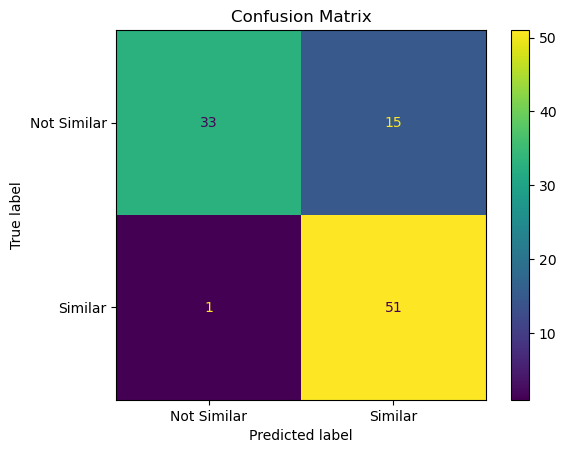

In [30]:
y_true = df_svr['similar']
y_pred = df_svr['pred_similar']
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

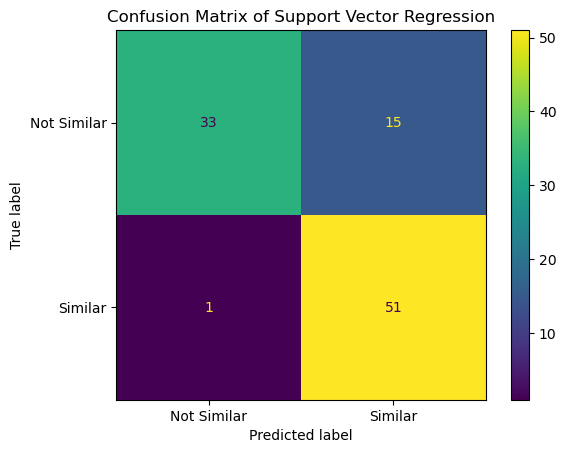

In [31]:
cm = np.array([[33, 15], [1, 51]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix of Support Vector Regression')
plt.show()

## Model 5: K-Nearest Neighbors (KNN) Regressionegression

In [32]:
df_knn = pd.read_csv(r"https://raw.githubusercontent.com/Mlzzzzz/MSU_CMSE830_Webapp/main/Datasets/preprocessed_dataset.csv")
features_knn = df_knn[["tanimoto_cdk_Extended", "TanimotoCombo"]]
targets_knn = df_knn[["frac_similar"]].values

In [33]:
param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
    'metric': ['euclidean', 'manhattan'] 
}

In [34]:
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(features_knn, targets_knn.squeeze())
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print("Best parameters:", best_params)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 4}


In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Prepare an array to store the predictions
predictions = np.zeros(len(df_svr))

# Iterate through each fold
for train_index, test_index in kf.split(features_knn):
    X_train, X_test = features_knn.iloc[train_index], features_knn.iloc[test_index]
    y_train, y_test = targets_knn[train_index], targets_knn[test_index]  

    # Define the model
    model = KNeighborsRegressor(metric='manhattan', n_neighbors=4)
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    preds = model.predict(X_test).flatten()

    # Store predictions
    predictions[test_index] = preds

# Add predictions back to the original DataFrame
df_knn['cv_predicted_knn'] = predictions

In [36]:
df_knn['pred_similar'] = (df_knn['cv_predicted_knn'] > 0.5).astype(int)
df_knn.head(5)

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_knn,pred_similar
0,1,0.567010,1.989,0.31,CYP2D6,"dis2D,sim3D",0.818182,1,0.526304,1
1,2,0.532051,1.782,0.34,HERG,"dis2D,sim3D",0.562500,1,0.609575,1
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,0.594859,1
3,4,0.558952,1.764,1.30,HERG,"dis2D,sim3D",0.750000,1,0.502597,1
4,5,0.452685,1.757,0.50,CYP2D6,"dis2D,sim3D",0.652174,1,0.599656,1


In [37]:
# find the misclassified pairs
mask = df_knn['similar'] != df_knn['pred_similar']

different_rows_knn = df_knn[mask]

different_rows_knn

,id_pair,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name,pair_type,frac_similar,similar,cv_predicted_knn,pred_similar
2,3,0.549206,1.778,0.49,CYP2D6,"dis2D,sim3D",0.380952,0,0.594859,1
5,6,0.626190,1.757,1.44,5HT2B,"dis2D,sim3D",0.411765,0,0.654865,1
17,18,0.602537,1.460,1.11,HERG,"dis2D,sim3D",0.448276,0,0.594313,1
19,20,0.608200,1.454,0.70,5HT2B,"dis2D,sim3D",0.480000,0,0.685283,1
22,23,0.348558,1.444,1.09,HERG,"dis2D,sim3D",0.550000,1,0.338358,0
23,24,0.538003,1.437,0.00,HERG,"dis2D,sim3D",0.461538,0,0.564748,1
28,29,0.848238,1.137,0.12,CYP2D6,"sim2D,dis3D",0.478261,0,0.689960,1
29,30,0.829787,1.271,0.30,CYP2D6,"sim2D,dis3D",0.500000,0,0.570709,1
31,32,0.801587,1.275,0.60,CYP2D6,"sim2D,dis3D",0.380952,0,0.531274,1
39,40,0.743271,1.292,0.20,5HT2B,"sim2D,dis3D",0.562500,1,0.414850,0


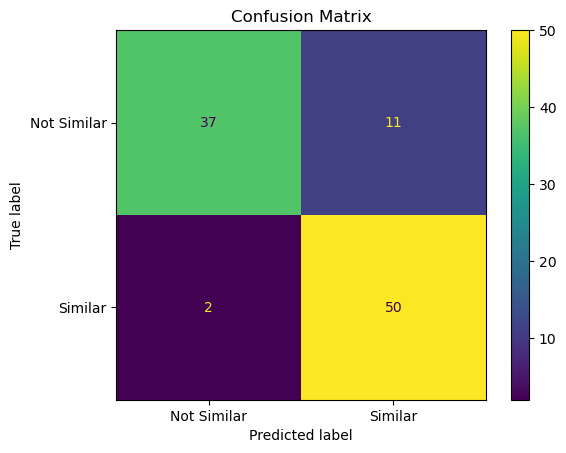

In [38]:
y_true = df_knn['similar']
y_pred = df_knn['pred_similar']
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

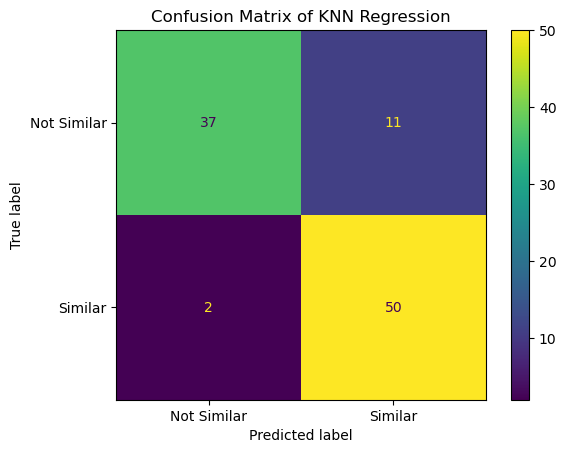

In [39]:
cm = np.array([[37, 11], [2, 50]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])

disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix of KNN Regression')
plt.show()